In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

RANDOM_SEED = 42

tf.enable_eager_execution()
tf.set_random_seed(RANDOM_SEED)

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Instructions for updating:
Use the retry module or similar alternatives.
TensorFlow version: 1.7.0
Eager execution: True


In [2]:
dataset_fp = "../DataSource/output1_2kg.csv"

def parse_csv(line):
    # Set field types
    example_defaults = [[0], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.]]
    parsed_line = tf.decode_csv(line, example_defaults, field_delim=";")
    # Last 10 fields are features, combine into single tensor
    features_ = tf.reshape(parsed_line[4:14], shape=[10])
    # Label is an index of beam's part where defect occurs
    label_ = tf.reshape(parsed_line[1], shape=[]) // 20
    label_ = tf.cast(label_, tf.int32)
    return features_, label_

dataset = tf.data.TextLineDataset(dataset_fp)
dataset = dataset.skip(1)

train_dataset_size = 8000
train_dataset = dataset.take(train_dataset_size)
train_dataset = train_dataset.map(parse_csv)
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(64)

test_dataset = dataset.skip(train_dataset_size)
test_dataset = test_dataset.map(parse_csv)
test_dataset = test_dataset.shuffle(buffer_size=10000)
test_dataset = test_dataset.batch(64)

# View a single example entry from a batch
features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor(
[0.178668 0.339281 0.487844 0.623748 0.738267 0.823269 0.889403 0.936653
 0.964992 0.974983], shape=(10,), dtype=float32)
example label: tf.Tensor(3, shape=(), dtype=int32)


In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(10,)),  # input shape required
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10)
])

def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)

# keep results for plotting
train_loss_results = []
train_accuracy_results = []
test_loss_results = []
test_accuracy_results = []

In [4]:
num_epochs = 10001

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    # Training loop - using batches of 64
    for x, y in tfe.Iterator(train_dataset):
        # Optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())

        # Track progress
        epoch_loss_avg(loss(model, x, y))  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    # Evaluate the model on the test dataset
    test_loss_avg = tfe.metrics.Mean()
    test_accuracy = tfe.metrics.Accuracy()

    for x, y in tfe.Iterator(test_dataset):
        prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
        test_loss_avg(loss(model, x, y))
        test_accuracy(prediction, y)

    test_loss_results.append(test_loss_avg.result())
    test_accuracy_results.append(test_accuracy.result())
    
    if epoch % 100 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
        
        print("Test set: Loss: {:.3f}, Accuracy: {:.3%}".format(test_loss_avg.result(),
                                                                test_accuracy.result()))

Epoch 000: Loss: 2.271, Accuracy: 13.412%
Test set: Loss: 2.280, Accuracy: 10.927%
Epoch 100: Loss: 1.553, Accuracy: 43.938%
Test set: Loss: 1.607, Accuracy: 34.236%
Epoch 200: Loss: 1.411, Accuracy: 49.587%
Test set: Loss: 1.468, Accuracy: 43.158%
Epoch 300: Loss: 1.341, Accuracy: 51.700%
Test set: Loss: 1.400, Accuracy: 50.677%
Epoch 400: Loss: 1.296, Accuracy: 52.675%
Test set: Loss: 1.354, Accuracy: 53.183%
Epoch 500: Loss: 1.263, Accuracy: 53.412%
Test set: Loss: 1.320, Accuracy: 55.038%
Epoch 600: Loss: 1.238, Accuracy: 53.538%
Test set: Loss: 1.293, Accuracy: 56.291%
Epoch 700: Loss: 1.216, Accuracy: 54.087%
Test set: Loss: 1.264, Accuracy: 56.341%
Epoch 800: Loss: 1.197, Accuracy: 54.763%
Test set: Loss: 1.243, Accuracy: 56.642%
Epoch 900: Loss: 1.180, Accuracy: 55.237%
Test set: Loss: 1.224, Accuracy: 57.694%
Epoch 1000: Loss: 1.164, Accuracy: 55.612%
Test set: Loss: 1.207, Accuracy: 57.644%
Epoch 1100: Loss: 1.149, Accuracy: 56.137%
Test set: Loss: 1.187, Accuracy: 57.644%
Ep

Epoch 9800: Loss: 0.681, Accuracy: 73.388%
Test set: Loss: 0.731, Accuracy: 70.226%
Epoch 9900: Loss: 0.679, Accuracy: 73.487%
Test set: Loss: 0.730, Accuracy: 70.426%
Epoch 10000: Loss: 0.678, Accuracy: 73.550%
Test set: Loss: 0.729, Accuracy: 70.376%


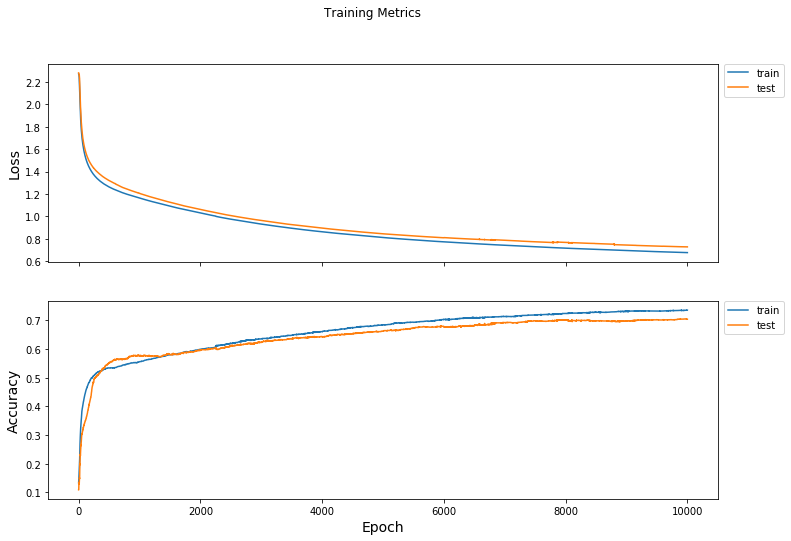

In [5]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results, label="train")
axes[0].plot(test_loss_results, label="test")
axes[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results, label="train")
axes[1].plot(test_accuracy_results, label="test")
axes[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [36]:
def predict(input_tensor):
    print("input tensor:", input_tensor)
    prediction = model(input_tensor)
    print("prediction:", prediction)
    probabilities = tf.contrib.util.constant_value(tf.nn.softmax(prediction))[0]
    plt.bar(range(10), probabilities, tick_label=range(10))
    plt.show()

input tensor: tf.Tensor(
[[0.18084054 0.3402412  0.48197126 0.604813   0.7087362  0.7937768
  0.8599215  0.9071722  0.9355156  0.9455064 ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[ -7.368324   -5.1394253  -4.9853725  -9.443573  -11.674418   -9.046854
   -9.980521  -14.011761   -8.58517    -6.3703957]], shape=(1, 10), dtype=float32)


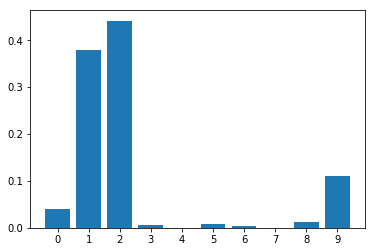

In [44]:
# Defect at (10.0, 10.0)
predict(tf.convert_to_tensor([[
    0.1808405343537812,
    0.340241207792753,
    0.481971255745045,
    0.6048129543274491,
    0.7087361584415679,
    0.7937768372479924,
    0.8599215006109187,
    0.9071721819778894,
    0.9355155539452132,
    0.9455063674119936
]]))

input tensor: tf.Tensor(
[[0.18082097 0.34134886 0.48163694 0.6044725  0.708416   0.7934547
  0.85959816 0.9068401  0.9351795  0.945171  ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[ -5.1013575  -3.4690087  -4.351266  -10.599114  -13.607382  -10.235837
  -10.893956  -14.897898   -8.612098   -6.408027 ]], shape=(1, 10), dtype=float32)


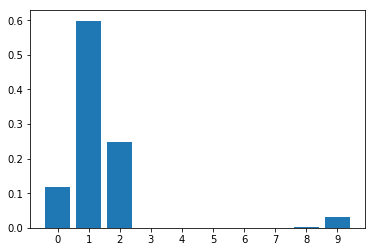

In [46]:
# Defect at (30.0, 10.0)
predict(tf.convert_to_tensor([[
    0.18082096973504352,
    0.341348857701782,
    0.48163692675938846,
    0.6044725114975288,
    0.7084159807258419,
    0.7934547190834322,
    0.8595981802038564,
    0.9068400783458913,
    0.9351794852474714,
    0.9451710252912452
]]))

input tensor: tf.Tensor(
[[0.17866014 0.34170333 0.48333317 0.6046702  0.7086142  0.7936529
  0.85979635 0.9070383  0.93537766 0.9453692 ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-10.478681   -7.480942   -5.8952904  -7.119632   -8.011385   -7.488905
   -9.72123   -15.118769  -10.010516   -6.9623976]], shape=(1, 10), dtype=float32)


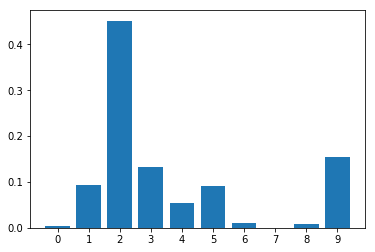

In [47]:
# Defect at (50.0, 10.0)
predict(tf.convert_to_tensor([[
    0.17866014537853742,
    0.3417033308847898,
    0.48333317464927705,
    0.6046702413780434,
    0.7086141659885471,
    0.7936528999109453,
    0.859796361799922,
    0.9070382599277853,
    0.9353776668294789,
    0.9453692068732497
]]))

input tensor: tf.Tensor(
[[0.1786674  0.33929124 0.4833701  0.606127   0.70849144 0.7935366
  0.85968584 0.9069268  0.93527013 0.94526094]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-14.531332  -10.470314   -7.019347   -4.877838   -4.3291597  -5.363514
   -8.292187  -14.046914  -10.295108   -7.0409117]], shape=(1, 10), dtype=float32)


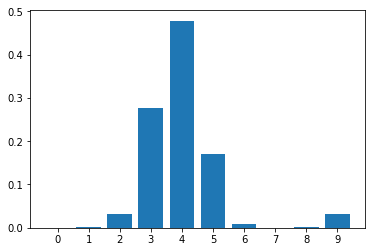

In [48]:
# Defect at (70.0, 10.0)
predict(tf.convert_to_tensor([[
    0.17866738980126073,
    0.33929125953322703,
    0.48337008528319453,
    0.6061270449353259,
    0.7084914417887473,
    0.7935365867912595,
    0.8596858454006034,
    0.9069268033691631,
    0.9352701344215305,
    0.9452609487039583
]]))

input tensor: tf.Tensor(
[[0.1786674  0.33927652 0.48101816 0.6061445  0.7100184  0.79342145
  0.85956824 0.9068188  0.9351622  0.945153  ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-16.116087  -11.539389   -7.35758    -4.7775755  -4.0232887  -4.4987097
   -6.7162704 -11.209941   -8.88587    -6.4034953]], shape=(1, 10), dtype=float32)


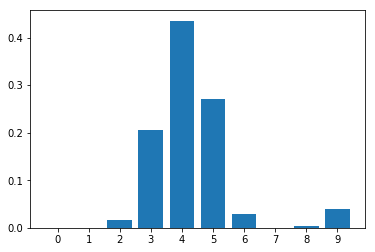

In [49]:
# Defect at (90.0, 10.0)
predict(tf.convert_to_tensor([[
    0.1786673931681812,
    0.33927653229026783,
    0.4810181492387796,
    0.6061444966710396,
    0.7100184172714854,
    0.793421460595827,
    0.8595682556383667,
    0.906818804669362,
    0.9351621790867785,
    0.945152992536065
]]))

input tensor: tf.Tensor(
[[0.17866738 0.3392772  0.48102307 0.6038621  0.7099885  0.7950041
  0.85946214 0.90671134 0.9350556  0.94504654]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-16.39731   -11.698267   -7.435609   -5.8183646  -5.356698   -4.2662554
   -5.060506   -7.388175   -6.508769   -5.3520446]], shape=(1, 10), dtype=float32)


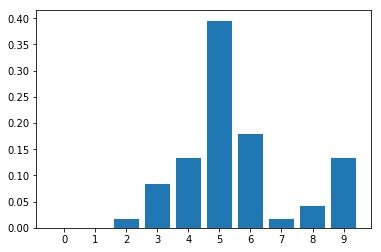

In [50]:
# Defect at (110.0, 10.0)
predict(tf.convert_to_tensor([[
    0.17866738555113773,
    0.33927720572311704,
    0.48102306275049245,
    0.6038620821725328,
    0.7099884928248044,
    0.7950041048675704,
    0.8594621583712174,
    0.906711311128509,
    0.9350556158687557,
    0.9450465188778997
]]))

input tensor: tf.Tensor(
[[0.17866738 0.3392772  0.48102307 0.6038609  0.7077906  0.7950022
  0.86111486 0.90659887 0.93494415 0.9449356 ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-16.23752   -11.649219   -7.547208   -7.0058565  -6.804247   -4.226821
   -3.6787822  -3.9434426  -4.2295985  -4.346916 ]], shape=(1, 10), dtype=float32)


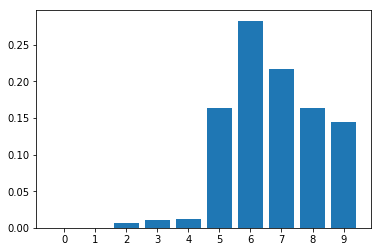

In [51]:
# Defect at (130.0, 10.0)
predict(tf.convert_to_tensor([[
    0.17866738554275302,
    0.339277206051974,
    0.4810230805343537,
    0.6038608917265234,
    0.7077906184250685,
    0.7950022500939448,
    0.8611148623176075,
    0.9065988370275837,
    0.9349441506091364,
    0.9449356400006531
]]))

input tensor: tf.Tensor(
[[0.17866215 0.33929476 0.48102447 0.60386074 0.7077952  0.79282963
  0.8610881  0.90831584 0.93484205 0.9448258 ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-14.552427  -10.557374   -7.3167953  -8.5404625  -8.88482    -4.9834504
   -3.476927   -2.4802468  -2.846898   -3.7549903]], shape=(1, 10), dtype=float32)


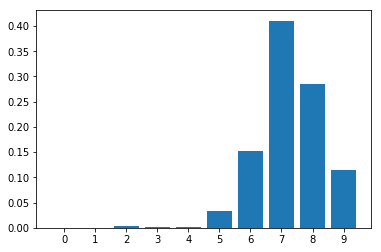

In [52]:
# Defect at (150.0, 10.0)
predict(tf.convert_to_tensor([[
    0.1786621469050847,
    0.33929476803500913,
    0.4810244815791084,
    0.6038607082449885,
    0.7077951777635609,
    0.7928296189169968,
    0.8610880863520557,
    0.9083158263953878,
    0.934842071003691,
    0.9448258560253059
]]))

input tensor: tf.Tensor(
[[0.17866215 0.33929476 0.48102447 0.6038607  0.70779526 0.7928275
  0.85896677 0.90824324 0.93660516 0.9446268 ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-11.927111   -8.671527   -6.660035   -9.783341  -10.932157   -6.3723054
   -4.662876   -3.7250335  -2.9789486  -3.8381374]], shape=(1, 10), dtype=float32)


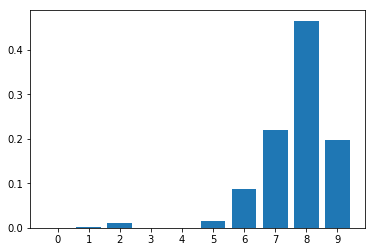

In [53]:
# Defect at (170.0, 10.0)
predict(tf.convert_to_tensor([[
    0.17866214691275106,
    0.3392947680489735,
    0.48102448165184675,
    0.6038607047058148,
    0.7077952468372659,
    0.792827512226871,
    0.8589667789681806,
    0.908243251688178,
    0.9366051629289601,
    0.9446267986500986
]]))

input tensor: tf.Tensor(
[[0.17866215 0.33929476 0.48102447 0.6038607  0.70779526 0.7928275
  0.85896343 0.9062224  0.93799955 0.9618735 ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-13.752942  -10.348149   -7.6406527  -9.07443    -9.183503   -5.2851105
   -3.703747   -2.4189155  -2.4815845  -3.5991988]], shape=(1, 10), dtype=float32)


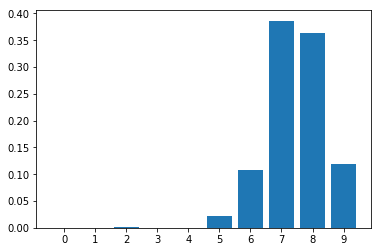

In [54]:
# Defect at (190.0, 10.0)
predict(tf.convert_to_tensor([[
    0.17866214691500926,
    0.3392947680534193,
    0.4810244816582007,
    0.6038607047382577,
    0.7077952455974407,
    0.792827509573063,
    0.8589634402312243,
    0.9062223843392093,
    0.9379995472141278,
    0.9618734423791657
]]))

input tensor: tf.Tensor(
[[0.17867227 0.3393038  0.481035   0.60387075 0.70780665 0.7928471
  0.85898775 0.90623295 0.9345781  0.9446501 ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-13.074495   -9.409701   -6.7724066  -8.272366   -8.93003    -5.8753896
   -5.387417   -6.204199   -4.894806   -4.672768 ]], shape=(1, 10), dtype=float32)


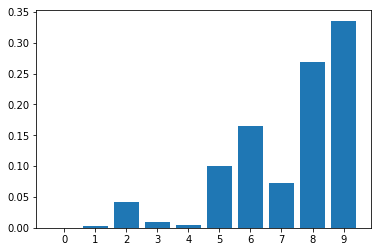

In [55]:
# No defect
predict(tf.convert_to_tensor([[
    0.17867226996276112,
    0.33930378939950734,
    0.481035002997144,
    0.6038707215010158,
    0.7078066565401998,
    0.7928470994528833,
    0.858987758901657,
    0.9062329262293288,
    0.934578099658785,
    0.9446500995784997
]]))

input tensor: tf.Tensor(
[[0.20840536 0.37970582 0.5213906  0.6442305  0.74817556 0.8332112
  0.8993544  0.9465954  0.9749427  0.98492825]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[ 110.84947   105.36977    62.52899   -21.184887  -84.07829   -86.38661
  -123.0402   -218.25356  -117.9125    -56.2838  ]], shape=(1, 10), dtype=float32)


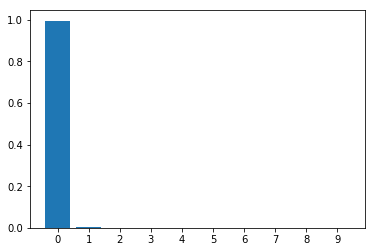

In [58]:
# Defect at (10.0, 14.0)
predict(tf.convert_to_tensor([[
    0.2084053671038296,
    0.37970581411662724,
    0.5213906117281436,
    0.6442304599276608,
    0.748175573470863,
    0.8332111802721919,
    0.8993543897444377,
    0.946595360708653,
    0.974942673311495,
    0.984928269210152
]]))

input tensor: tf.Tensor(
[[0.18664783 0.3440338  0.48581174 0.6086457  0.71258926 0.7976247
  0.8637679  0.9110089  0.9393562  0.94934183]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[  8.015734    6.6556826   0.305485  -10.979378  -17.417934  -17.892326
  -24.536951  -40.284187  -21.966997  -12.46861  ]], shape=(1, 10), dtype=float32)


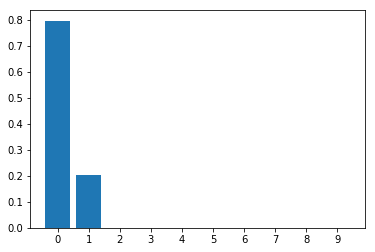

In [59]:
# Defect at (10.0, 6.0)
predict(tf.convert_to_tensor([[
    0.18664783343182367,
    0.3440338215642104,
    0.48581172726904326,
    0.6086456507762161,
    0.7125892832227723,
    0.7976247214005071,
    0.8637679342008161,
    0.9110089051505142,
    0.9393562177531636,
    0.9493418136518551
]]))

input tensor: tf.Tensor(
[[0.1786674  0.33927664 0.48106042 0.6095861  0.70847636 0.7934835
  0.85963124 0.9068722  0.93521553 0.94520634]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-14.87184   -10.097198   -6.2178116  -4.2029247  -4.314351   -5.494341
   -8.796318  -15.515972  -11.495162   -7.575913 ]], shape=(1, 10), dtype=float32)


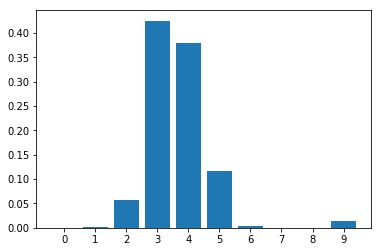

In [61]:
# Defect at (80.0, 10.0)
predict(tf.convert_to_tensor([[
    0.17866739596690678,
    0.3392766278130301,
    0.48106040917021586,
    0.6095861442730324,
    0.7084763728715435,
    0.7934835045808317,
    0.8596312374520064,
    0.9068722140965333,
    0.9352155451843441,
    0.9452063594619821
]]))

input tensor: tf.Tensor(
[[0.17866813 0.33928114 0.4882161  0.62405294 0.7382702  0.82326305
  0.8894036  0.93665373 0.96499294 0.97498447]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-44.033127   -21.018173     0.25544238  13.473587     8.768015
    4.3921022   -1.6290605  -14.961985   -20.815237   -11.541506  ]], shape=(1, 10), dtype=float32)


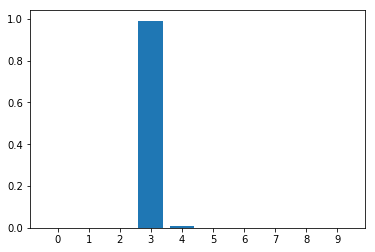

In [62]:
# Defect at (70.0, 14.0)
predict(tf.convert_to_tensor([[
    0.17866813147982466,
    0.3392811424393098,
    0.48821610818944466,
    0.6240529585805219,
    0.7382702220498087,
    0.823263039646359,
    0.8894035848306389,
    0.9366537413490406,
    0.9649929191061973,
    0.9749844626934407
]]))

input tensor: tf.Tensor(
[[0.17866704 0.3392875  0.48236826 0.6109506  0.71132606 0.79639846
  0.86254996 0.9097909  0.9381342  0.948125  ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-17.129847  -10.611743   -5.248522   -2.545704   -3.4150517  -4.915804
   -8.642708  -16.429508  -12.914708   -8.195951 ]], shape=(1, 10), dtype=float32)


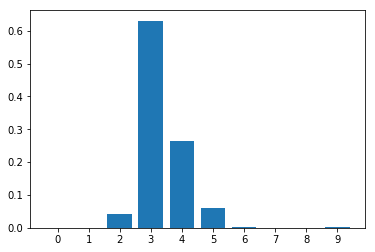

In [63]:
# Defect at (70.0, 6.0)
predict(tf.convert_to_tensor([[
    0.17866704134216202,
    0.3392874849059781,
    0.4823682511684362,
    0.6109505696834808,
    0.7113260722852263,
    0.7963984793187607,
    0.8625499528703889,
    0.9097908622557338,
    0.9381341937426296,
    0.9481250080278378
]]))

input tensor: tf.Tensor(
[[0.17866215 0.33929476 0.48102447 0.60386074 0.7077854  0.7928269
  0.86086655 0.91309774 0.94630986 0.95626915]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-10.47636     -8.078808    -6.692586   -12.525782   -13.905325
   -6.109595    -2.5691419    0.01464546  -0.7679466   -2.9638934 ]], shape=(1, 10), dtype=float32)


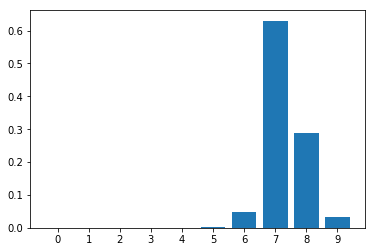

In [64]:
# Defect at (150.0, 14.0)
predict(tf.convert_to_tensor([[
    0.1786621469021938,
    0.33929476806433645,
    0.48102447916278157,
    0.6038607524216458,
    0.7077854182079706,
    0.7928268908401633,
    0.860866544272033,
    0.9130977574436594,
    0.9463098826126599,
    0.9562691747102455
]]))

input tensor: tf.Tensor(
[[0.17866215 0.33929476 0.48102447 0.60386074 0.707786   0.7928137
  0.86100477 0.910504   0.935915   0.945924  ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-14.11662   -10.3434     -7.258769   -9.183434   -9.597399   -4.9138494
   -3.065151   -1.9387248  -2.5825706  -3.6700685]], shape=(1, 10), dtype=float32)


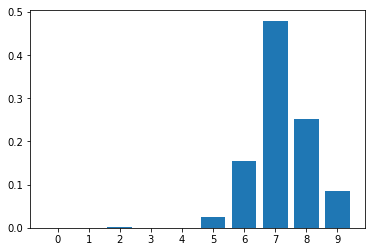

In [65]:
# Defect at (150.0, 6.0)
predict(tf.convert_to_tensor([[
    0.17866214691022284,
    0.33929476808124515,
    0.4810244790303662,
    0.6038607576386035,
    0.7077860174516186,
    0.7928137101802392,
    0.8610047657323178,
    0.9105039784107096,
    0.9359149919836193,
    0.9459239699219951
]]))